# Reinforce & Actor-Advantage Critic (A2C)

[You can find the original paper here](https://arxiv.org/pdf/1602.01783.pdf).

## Imports

In [1]:
!pip install torch==1.1.0 torchvision pyvirtualdisplay tqdm matplotlib seaborn pandas

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path

import random, os.path, math, glob, csv, base64, itertools
import gym
from gym.wrappers import Monitor

In [3]:
def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1033'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1033'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

## Intro

In this tutorial we will focus on Deep Reinforcement Learning with **Reinforce** and the **Actor-Advantage Critic** algorithm. This tutorial is composed of:
* A quick reminder of the RL setting,
* A theoritical approch of Reinforce
* A theoritical approch of A2C,
* An introduction to the deep learning framework: **PyTorch**, 
* A coding part with experiments.


## Introduction to PyTorch

*If you already know PyTorch you can skip this part. From this part on we assume that you have some experience with Python and Numpy.*

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |



PyTorch works in a very similar way as Numpy and PyTorch's Tensors are the equivalent of Numpy's Arrays.

You can initialize an zero filled tensor just like in numpy.

In [5]:
torch.zeros(5,3)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [6]:
torch.eye(3)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])

You can also convert an array to a tensor.

In [7]:
torch.tensor(np.eye(3))

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], dtype=torch.float64)

And you can transform a tensor to an array.

In [8]:
torch.tensor(np.eye(3)).numpy()

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

You can sum, substract, multiply arrays just like in numpy.

In [9]:
a = torch.randint(0,10,(2,3))
print(a)

tensor([[3, 7, 1],
        [0, 5, 7]])


In [10]:
b = torch.randint(0,10,(2,3))
print(b)

tensor([[1, 6, 7],
        [7, 2, 3]])


In [11]:
print(f'a + b = {a + b}')
print(f'a * b = {a * b}')

a + b = tensor([[ 4, 13,  8],
        [ 7,  7, 10]])
a * b = tensor([[ 3, 42,  7],
        [ 0, 10, 21]])


You can make matrix products.

In [12]:
a @ b.t()

tensor([[52, 38],
        [79, 31]])

### AUTOGRAD: automatic differentiation

The autograd package provides automatic differentiation for all operations on Tensors. It is a define-by-run framework, which means that your backprop is defined by how your code is run, and that every single iteration can be different.

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.

## Reminder of the RL setting

As always we will consider a MDP $M = (\mathcal{X}, \mathcal{A}, p, r, \gamma)$ with:
* $\mathcal{X}$ the state space,
* $\mathcal{A}$ the action space,
* $p(x^\prime \mid x, a)$ the transition probability,
* $r(x, a, x^\prime)$ the reward of the transition $(x, a, x^\prime)$,
* $\gamma \in [0,1)$ is the discount factor.

A policy $\pi$ is a mapping from the state space $\mathcal{X}$ to the probability of selecting each action.

The action value function of a policy is the overall expected reward from a state action. $Q^\pi(s, a) = \mathbb{E}_{\tau \sim \pi}\big[R(\tau) \mid s_0=s, a_0=a\big]$ where $R(\tau)$ is the random variable defined as the sum of the discounted reward.

The goal is to maximize the agent's reward.

$$ J(\pi) = \mathbb{E}_{\tau \sim \pi}\big[ \sum_{t} \gamma^t R_t \mid x_0, \pi \big]$$

# Gym Environnement

In this lab and also the next one we are going to use the [OpenAI's Gym library](https://gym.openai.com/envs/). This library provides a large number of environnements to test RL algorithm.

We will focus on three different environnements in this lab but we encourage you to test other ones.
* Acrobot-v1
* CartPole-v1
* MountainCar-v0

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environnement is loaded with the command `env = gym.make(env_id)`. Once the environnement is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

### Carpole

In [13]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

In [14]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

### Acrobot-v1

In [15]:
# We load Acrobot-v1
env = gym.make('Acrobot-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

In [16]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

### MountainCar-v0

In [17]:
# We load Acrobot-v1
env = gym.make('MountainCar-v0')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

In [18]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

### Introduction

Reinforce is an actor-based **on policy** method. The policy $\pi_{\theta}$ is parametrized by a function approximator (e.g. a neural network).

Recall: $$ J(\pi) = \mathbb{E}_{\tau \sim \pi}\big[ \sum_{t} \gamma^t R_t \mid x_0, \pi \big].$$

To update the parameters $\theta$ of the policy, one has to do gradient ascent: $\theta_{k+1} = \theta_{k} + \alpha \nabla_{\theta}J(\pi_{\theta})|_{\theta_{k}}$.

Advantages of this approach:
- Compared to a Q-learning approach, here the policy is directly parametrized so a small change of the parameters will not dramatically change the policy whereas this is not the case for Q-learning approaches.
- The stochasticity of the policy allows exploration. In off policy learning, one has to deal with both a behaviour policy and an exploration policy.

### Policy Gradient Theorem

**Q.1: Prove the Policy Gradient Theorem:** $$ \displaystyle \nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}\left[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau)}\right]$$

Hint 1 - The probability of a trajectory $\tau = (s_{0}, a_{0},\dots, s_{T+1}$) with action chosen from $\displaystyle \pi_{\theta}$ is $P(\tau|\theta) = \rho_{0}(s_{0})\prod_{t=0}^{T}P\left(s_{t+1}|s_{t}, a_{t}\right) \pi_{\theta}(a_{t}|s_{t})$

Hint 2 - Gradient-log trick: $  \nabla_{\theta}P(\tau|\theta)= P(\tau|\theta)\nabla_{\theta}\log P(\tau|\theta). $

The policy gradient can therefore be approximated with:
$$ \hat{g} = \frac{1}{|\mathcal{D}|} \sum_{\tau \in \mathcal{D}} \sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) R(\tau) $$

**Q.2: Implement the REINFORCE algorithm**

First we will define our model:

In [19]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

It is always nice to visualize the differents layers of our model.

In [20]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax()
  )
)


In [21]:
class BaseAgent:
    
    def __init__(self, dim_observation, n_actions, gamma):
        self.model = Model(dim_observation=dim_observation, n_actions=n_actions)
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=0.01)
    
    def _make_returns(self, rewards):
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = rewards[t] + self.gamma * returns[t + 1]
        return returns
    
    def optimize_model(self):
        raise NotImplementedError
    
    def train(self, env, n_trajectories, n_update):
        for episode in range(n_update):
            mean_reward, std_reward, min_reward, max_reward = self.optimize_model(env, n_trajectories)
            print("Episode {}".format(episode+1))
            print("Reward:μσmM {:.2f} {:.2f} {:.2f} {:.2f}"
              .format(mean_reward, std_reward, min_reward, max_reward))

    def evaluate(self, env, n_trajectories):
        reward_trajectories = np.zeros(n_trajectories)
        for i in range(n_trajectories):
            # New episode
            observation = env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False
            
            while not done:
                env.render()
                action = self.model.select_action(observation)
                observation, reward, done, info = env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward
            
            reward_trajectories[i] = reward_episode
        env.close()
        print("Reward:μσmM {:.2f} {:.2f} {:.2f} {:.2f}"
              .format(reward_trajectories.mean(), reward_trajectories.std(), 
                      reward_trajectories.min(), reward_trajectories.max()))
        

In [22]:
class SimpleAgent(BaseAgent):
    
    def optimize_model(self, env, n_trajectories):
        weighted_logproba = torch.zeros(n_trajectories)
        reward_trajectories = np.zeros(n_trajectories)

        for i in range(n_trajectories):
            # New episode
            observation = env.reset()
            rewards_episode = []
            logproba_episode = []
            discount_factor = 1
            observation = torch.tensor(observation, dtype=torch.float)
            done = False
            
            while not done:
                action = self.model.select_action(observation)
                logproba_episode.append(torch.log(self.model.forward(observation))[action])
                # Interaction with the environment
                observation, reward, done, info = env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                rewards_episode.append(discount_factor * reward)
                discount_factor *= self.gamma
            
            cum_rewards_episode = np.sum(rewards_episode)
            weighted_logproba[i]= cum_rewards_episode * torch.cat(logproba_episode).sum()
            reward_trajectories[i] = cum_rewards_episode
            
        loss = - weighted_logproba.mean()
        
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories.mean(), reward_trajectories.std(), reward_trajectories.min(), reward_trajectories.max()


In [23]:
# Make the environment
env = gym.make("CartPole-v1")

# Seeds
seed = 1
env.seed(seed=seed)
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)

observation = env.reset()

n_actions = env.action_space.n
dim_observation = observation.shape[0]

Agent = SimpleAgent(dim_observation=dim_observation, n_actions=n_actions, gamma=1)
Agent.train(env=env, n_trajectories=50, n_update=50)

Episode 1
Reward:μσmM 19.44 9.94 8.00 48.00
Episode 2
Reward:μσmM 21.26 10.15 8.00 58.00
Episode 3
Reward:μσmM 20.42 9.13 8.00 56.00
Episode 4
Reward:μσmM 19.28 8.99 8.00 55.00
Episode 5
Reward:μσmM 20.62 7.93 10.00 37.00
Episode 6
Reward:μσmM 22.54 12.58 8.00 77.00
Episode 7
Reward:μσmM 21.64 10.05 9.00 54.00
Episode 8
Reward:μσmM 26.70 13.61 11.00 89.00
Episode 9
Reward:μσmM 24.00 13.84 10.00 64.00
Episode 10
Reward:μσmM 22.54 12.84 9.00 64.00
Episode 11
Reward:μσmM 23.64 12.61 9.00 89.00
Episode 12
Reward:μσmM 25.46 12.30 10.00 69.00
Episode 13
Reward:μσmM 23.20 8.82 10.00 49.00
Episode 14
Reward:μσmM 23.56 11.03 9.00 49.00
Episode 15
Reward:μσmM 23.94 18.52 10.00 132.00
Episode 16
Reward:μσmM 31.60 20.62 10.00 93.00
Episode 17
Reward:μσmM 29.34 18.09 10.00 93.00
Episode 18
Reward:μσmM 29.42 19.27 9.00 112.00
Episode 19
Reward:μσmM 31.10 16.00 12.00 88.00
Episode 20
Reward:μσmM 29.92 15.94 9.00 77.00
Episode 21
Reward:μσmM 28.12 13.73 11.00 69.00
Episode 22
Reward:μσmM 35.40 24.27 1

### Don't let the past distract you

- The sum of rewards during one episode has a high variance which affects the performance of this version of REINFORCE.
- To assess the quality of an action, it make more sens to take into consideration only the rewards obtained after taking this action.
- It can be proven that $$  \nabla_{\theta} J(\pi_{\theta}) = E_{\tau \sim \pi_{\theta}}\left[{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \sum_{t'=t}^T R(s_{t'}, a_{t'}, s_{t'+1})}\right].$$
- Bonus: proof of this claim.
- This has for effect to reduce the variance. Past rewards have zero mean but nonzero variance so they just add noise.  

**Q3: Implement this enhance version of REINFORCE**

In [24]:
class EnhanceAgent(BaseAgent):
    
    def optimize_model(self, env, n_trajectories):
        weighted_logproba = torch.zeros(n_trajectories)
        reward_trajectories = np.zeros(n_trajectories)

        for i in range(n_trajectories):
            # New episode
            observation = env.reset()
            rewards_episode = []
            logproba_episode = []
            discount_factor = 1
            observation = torch.tensor(observation, dtype=torch.float)
            done = False
            
            while not done:
                action = self.model.select_action(observation)
                logproba_episode.append(torch.log(self.model.forward(observation))[action])
                # Interaction with the environment
                observation, reward, done, info = env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                rewards_episode.append(discount_factor * reward)
                discount_factor *= self.gamma
            
            inverse_cum_rewards = self._make_returns(rewards_episode)
            reward_trajectories[i] = inverse_cum_rewards[0]
            inverse_cum_rewards = torch.tensor(inverse_cum_rewards, dtype=torch.float)
            weighted_logproba[i]= torch.sum(inverse_cum_rewards * torch.cat(logproba_episode))
            
        loss = - weighted_logproba.mean()
        
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories.mean(), reward_trajectories.std(), reward_trajectories.min(), reward_trajectories.max()
   

In [25]:
Agent = EnhanceAgent(dim_observation=dim_observation, n_actions=n_actions, gamma=1)
Agent.train(env=env, n_trajectories=50, n_update=50)

Episode 1
Reward:μσmM 20.72 10.90 9.00 60.00
Episode 2
Reward:μσmM 21.54 9.81 10.00 54.00
Episode 3
Reward:μσmM 23.74 13.46 10.00 69.00
Episode 4
Reward:μσmM 25.54 13.12 9.00 72.00
Episode 5
Reward:μσmM 27.58 15.44 11.00 80.00
Episode 6
Reward:μσmM 25.26 12.04 12.00 76.00
Episode 7
Reward:μσmM 26.74 15.13 8.00 67.00
Episode 8
Reward:μσmM 29.32 13.61 11.00 68.00
Episode 9
Reward:μσmM 28.84 15.98 11.00 84.00
Episode 10
Reward:μσmM 30.92 19.93 10.00 106.00
Episode 11
Reward:μσmM 29.54 15.78 10.00 84.00
Episode 12
Reward:μσmM 35.36 16.17 13.00 80.00
Episode 13
Reward:μσmM 36.32 21.94 9.00 123.00
Episode 14
Reward:μσmM 40.06 19.07 14.00 93.00
Episode 15
Reward:μσmM 41.20 28.30 11.00 139.00
Episode 16
Reward:μσmM 45.24 25.57 11.00 148.00
Episode 17
Reward:μσmM 47.00 22.18 11.00 124.00
Episode 18
Reward:μσmM 49.04 24.80 17.00 115.00
Episode 19
Reward:μσmM 46.60 21.34 13.00 131.00
Episode 20
Reward:μσmM 48.74 19.05 21.00 91.00
Episode 21
Reward:μσmM 52.80 34.78 17.00 254.00
Episode 22
Reward:μ

## From REINFORCE to A2C

### The idea behind A2C

The need of a critic.

### A2C

In [26]:
env_id = 'CartPole-v1'
env = gym.make(env_id)

In [27]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out

In [28]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [29]:
class A2CAgent:

    def __init__(self, gamma, env_id):
        self.env_id = env_id
        self.env = gym.make(env_id)
        self.gamma = gamma
        
        # Our two networks
        self.value_network = ValueNetwork(env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.Adam(self.value_network.parameters(), lr=0.01)
        self.actor_network_optimizer = optim.Adam(self.actor_network.parameters(), lr=0.01)
        
    # This function is for computing the cumulative discounted reward alongside the advantage
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), [next_value], axis=0)
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        advantages = returns - values
        return returns, advantages

    # Perform a training by batch
    def training_batch(self, epochs, batch_size):
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        rewards_test = []

        for epoch in tqdm.trange(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                values[i] = self.value_network(torch.tensor(observation, dtype=torch.float)).detach().numpy()
                policy = self.actor_network(torch.tensor(observation, dtype=torch.float))
                actions[i] = torch.multinomial(policy, 1).detach().numpy()
                observation, rewards[i], dones[i], _ = self.env.step(actions[i])

                if dones[i]:
                    observation = self.env.reset()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network(torch.tensor(observation, dtype=torch.float)).detach().numpy()[0]

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self._learn_batch(observations, actions, returns, advantages)

            # Test it every 50 batches
            if epoch % 50 == 0 or epoch == epoch - 1:
                rewards_test.append(self.evaluate(50))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {rewards_test[-1].mean()}, Std: {rewards_test[-1].std()}')

                # Early stopping
                if rewards_test[-1].mean() > 490:
                    print('Early stopping !')
                    break
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r);
        return rewards_test

    def _learn_batch(self, observations, actions, returns, advantages):
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)

        # MSE for the values
        self.value_network_optimizer.zero_grad()
        values = self.value_network(observations)
        loss_value = 1 * F.mse_loss(values, returns)
        loss_value.backward()
        self.value_network_optimizer.step()

        # Actor loss
        self.actor_network_optimizer.zero_grad()
        policies = self.actor_network(observations)
        loss_policy = ((actions.float() * policies.log()).sum(-1) * advantages).mean()
        loss_entropy = - (policies * policies.log()).sum(-1).mean()
        loss_actor = - loss_policy - 0.0001 * loss_entropy
        loss_actor.backward()
        self.actor_network_optimizer.step()
        
        return loss_value, loss_actor    

    def evaluate(self, n_trajectories, render=False):
        reward_trajectories = np.zeros(n_trajectories)
        for i in range(n_trajectories):
            # New episode
            observation = self.env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False

            while not done:
                if render:
                    self.env.render()
                policy = self.actor_network(observation)
                action = torch.multinomial(policy, 1)
                observation, reward, done, info = self.env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward

            reward_trajectories[i] = reward_episode
        self.env.close()
        return reward_trajectories

  0%|          | 1/1000 [00:00<04:11,  3.97it/s]/home/raphael/Dev/venv/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|          | 5/1000 [00:00<03:03,  5.41it/s]

Epoch 0/1000: Mean rewards: 22.38, Std: 10.665627032669013


  6%|▌         | 56/1000 [00:02<01:24, 11.17it/s]

Epoch 50/1000: Mean rewards: 140.1, Std: 72.59621202239136


 10%|▉         | 99/1000 [00:04<00:35, 25.64it/s]

Epoch 100/1000: Mean rewards: 496.32, Std: 25.759999999999998
Early stopping !


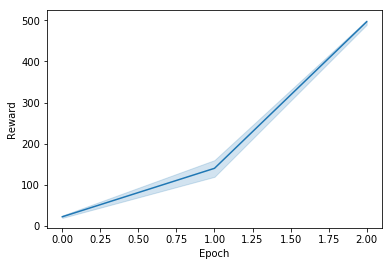

In [30]:
env_id = 'CartPole-v1'
agent = A2CAgent(0.99, env_id)
rewards = agent.training_batch(1000, 64)

## Warning
This class is big because there are two types of learning [Batch, Episode] available

In [31]:
class A2CAgent:

    def __init__(self, gamma, env_id):
        self.env_id = env_id
        self.env = gym.make(env_id)
        self.gamma = gamma
        
        # Our two networks
        self.value_network = ValueNetwork(env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.Adam(self.value_network.parameters(), lr=0.01)
        self.actor_network_optimizer = optim.Adam(self.actor_network.parameters(), lr=0.01)

    # This function is for computing the cumulative discounted reward
    # Hint: use it during training_episode
    def _make_returns(self, rewards):
        returns = np.zeros_like(rewards)
        returns[-1] = rewards[-1]
        for t in reversed(range(len(rewards) - 1)):
            returns[t] = (rewards[t] + self.gamma * returns[t + 1])
        return returns

    # This function is for computing the cumulative discounted reward alongside the advantage
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), [next_value], axis=0)
        for t in reversed(range(rewards.shape[0])):
            returns[t] = rewards[t] + self.gamma * returns[t + 1] * (1 - dones[t])
        returns = returns[:-1]
        advantages = returns - values
        return returns, advantages
    
    # Perform a training by episodes
    def train_episode(self, n_trajectories, n_update):
        mean_rewards = np.zeros(n_update)
        losses = np.zeros(n_update)

        for episode in tqdm.trange(n_update):
            loss, mean_reward, std_reward, min_reward, max_reward = self._learn_episode(n_trajectories)
            mean_rewards[episode] = mean_reward
            losses[episode] = loss

        plt.plot(mean_rewards)
        plt.show()
        
    def _learn_episode(self, n_trajectories):
        reward_trajectories = []
        value_losses = []
        policy_losses = []
        entropy_losses = []
        
        for i in range(n_trajectories):
            # Get a trajectory
            rewards_episode, logproba_episode, values_episode, entropy_episode = self.collect_trajectory()
            reward_trajectories.append(rewards_episode.sum())
            
            # Compute the returns
            returns = torch.tensor(self._make_returns(rewards_episode), dtype=torch.float32)
            
            # Compute the loss of the value network
            value_loss = F.mse_loss(values_episode, returns)
            value_losses.append(value_loss)

            advantage = returns - values_episode.detach()
            
            # Compute the loss of the actor network
            policy_loss = torch.mean(logproba_episode * advantage)
            policy_losses.append(policy_loss)
            entropy_losses.append(entropy_episode)

        value_losses = torch.stack(value_losses).mean()
        policy_losses = torch.stack(policy_losses).mean()
        entropy_losses = torch.stack(entropy_losses).mean()
        loss_actor = - policy_losses - 0.0001 * entropy_losses
        
        # Perform optimization step on the value network
        self.value_network_optimizer.zero_grad()
        value_losses.backward()
        self.value_network_optimizer.step()

        # Perform optimization step on the actor network
        self.actor_network_optimizer.zero_grad()
        loss_actor.backward()
        self.actor_network_optimizer.step()

        loss = value_losses + loss_actor
        reward_trajectories = np.array(reward_trajectories)
        return loss.detach().numpy(), reward_trajectories.mean(), reward_trajectories.std(), reward_trajectories.min(), reward_trajectories.max()

    def collect_trajectory(self):
        # New episode
        observation = self.env.reset()
        rewards_episode = []
        values_episode = []
        logproba_episode = []
        entropy_episode = []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False

        while not done:
            value = self.value_network(observation)
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            values_episode.append(value)
            entropy_episode.append(- torch.sum(policy * torch.log(policy)))
            logproba_episode.append(policy.log()[action])

            # Interaction with the environment
            observation, reward, done, info = self.env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            rewards_episode.append(reward)

        rewards_episode = np.array(rewards_episode)
        logproba_episode = torch.cat(logproba_episode)
        values_episode = torch.cat(values_episode)
        entropy_episode = torch.sum(torch.stack(entropy_episode))

        return rewards_episode, logproba_episode, values_episode, entropy_episode

    # Perform a training by batch
    def training_batch(self, epochs, batch_size):
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        rewards_test = []

        for epoch in tqdm.trange(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                values[i] = self.value_network(torch.tensor(observation, dtype=torch.float)).detach().numpy()
                policy = self.actor_network(torch.tensor(observation, dtype=torch.float))
                actions[i] = torch.multinomial(policy, 1).detach().numpy()
                observation, rewards[i], dones[i], _ = self.env.step(actions[i])

                if dones[i]:
                    observation = self.env.reset()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network(torch.tensor(observation, dtype=torch.float)).detach().numpy()[0]

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self._learn_batch(observations, actions, returns, advantages)

            # Test it every 50 batches
            if epoch % 50 == 0 or epoch == epoch - 1:
                rewards_test.append(self.evaluate(50))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {rewards_test[-1].mean()}, Std: {rewards_test[-1].std()}')

                # Early stopping
                if rewards_test[-1].mean() > 490:
                    print('Early stopping !')
                    break
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r);
        return rewards_test

    def _learn_batch(self, observations, actions, returns, advantages):
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns[:, None], dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)

        # MSE for the values
        self.value_network_optimizer.zero_grad()
        values = self.value_network(observations)
        loss_value = 1 * F.mse_loss(values, returns)
        loss_value.backward()
        self.value_network_optimizer.step()

        # Actor loss
        self.actor_network_optimizer.zero_grad()
        policies = self.actor_network(observations)
        loss_policy = ((actions.float() * policies.log()).sum(-1) * advantages).mean()
        loss_entropy = - (policies * policies.log()).sum(-1).mean()
        loss_actor = - loss_policy - 0.0001 * loss_entropy
        loss_actor.backward()
        self.actor_network_optimizer.step()
        
        return loss_value, loss_actor    

    def evaluate(self, n_trajectories, render=False):
        reward_trajectories = np.zeros(n_trajectories)
        for i in range(n_trajectories):
            # New episode
            observation = self.env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode = 0
            done = False

            while not done:
                if render:
                    self.env.render()
                policy = self.actor_network(observation)
                action = torch.multinomial(policy, 1)
                observation, reward, done, info = self.env.step(int(action))
                observation = torch.tensor(observation, dtype=torch.float)
                reward_episode += reward

            reward_trajectories[i] = reward_episode
        self.env.close()
        return reward_trajectories